In [1]:
# Ref.)
# https://github.com/Shedka/citiesatnight/blob/5f17f1b323740cea77623ad038a8e713c25849db/frqi.py
# https://arxiv.org/pdf/1812.11042.pdf
# https://qiskit.org/textbook/ch-applications/image-processing-frqi-neqr.html

import qiskit
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
from qiskit.extensions import UnitaryGate
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torchvision import datasets, transforms

%matplotlib inline

def genGraycode(nbit):
    graycode = ['0', '1']

    for _ in range(nbit-1):
        mirrored = reversed(graycode)
        graycode = ['0'+g for g in graycode]
        graycode = graycode + ['1'+m for m in mirrored]
    
    return graycode

def MCRY(theta, n_controlbit):
    t = 2**(n_controlbit + 1)
    mat = np.identity(t)
    # higher qubit indices are more significant (little endian convention)
    #      ┌───┐
    # q_0: ┤ X ├
    #      └─┬─┘
    # q_1: ──■──
    #        │
    # q_2: ──■──
#     mat[t-2, t-2] = np.cos(theta/2)
#     mat[t-2, t-1] = -np.sin(theta/2)
#     mat[t-1, t-2] = np.sin(theta/2)
#     mat[t-1, t-1] = np.cos(theta/2)

    # q_0: ──■──
    #        │
    # q_1: ──■──
    #      ┌─┴─┐
    # q_2: ┤ X ├
    #      └───┘
    mat[t//2-1, t//2-1] = np.cos(theta/2)
    mat[t//2-1, t-1] = -np.sin(theta/2)
    mat[t-1, t//2-1] = np.sin(theta/2)
    mat[t-1, t-1] = np.cos(theta/2)

    return UnitaryGate(mat, label=f'theta={theta}')

5


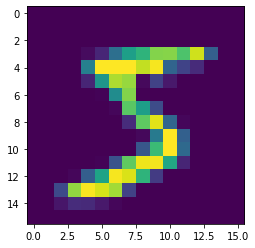

In [8]:
# img_folder = "C:/Users/thesi/Downloads/MNIST Dataset JPG format/MNIST Dataset JPG format/MNIST - JPG - training/0/"
# img_path = img_folder + "1.jpg"
# img_folder = "C:/Users/thesi/Downloads/MNIST Dataset JPG format/MNIST Dataset JPG format/MNIST - JPG - training/1/"
# img_path = img_folder + "3.jpg"

# img = cv2.imread(img_path, 0)

train_data = datasets.MNIST(root='./data', train=True, download=True)

img, label = train_data[0]
img = np.array(img)

""" image reszie from 28x28 to n x n """
img_size = 16
img = cv2.resize(img, dsize=(img_size, img_size), interpolation=cv2.INTER_LINEAR)

""" Image Visualization """
print(label)
plt.imshow(img)
plt.show()

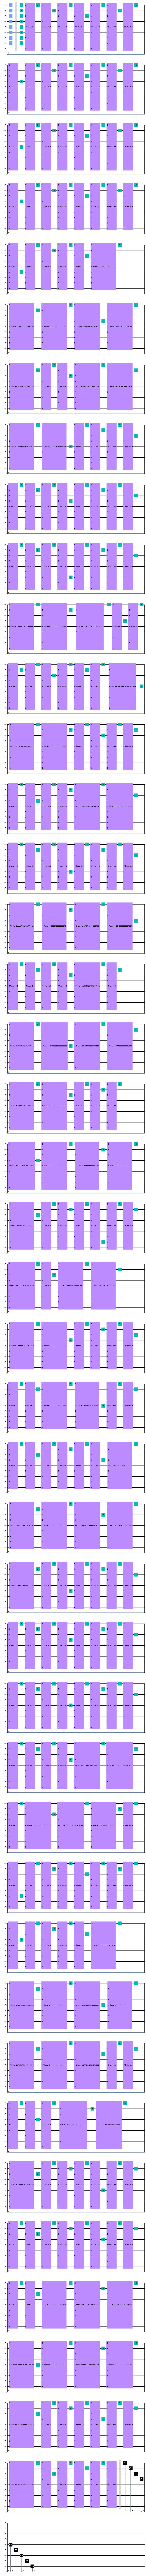

In [9]:
""" 2d to 1d """
img = img.reshape(img_size*img_size)

""" Nomralization (0~1 == sin(0)~sin(pi/2)) """
img = img / 255.0

""" calculate theta """
img = np.arcsin(img)

# provider = IBMQ.load_account()


""" Create Multi-controlled RY Gate """
k = int(np.ceil(np.log2(img_size)))

""" Design circuit """
qc = QuantumCircuit(2*k+1, 2*k+1)

qc.h(range(0, 2*k))

graycode = genGraycode(2*k)

qc.barrier()
# for i, e in enumerate(img):
#     if i == 0:
#         qc.x(range(0, 2*k))
#     else:
#         for j in range(2*k):
#             if graycode[i-1][j] != graycode[i][j]:
#                 qc.x(j)
#                 break
#     mcry = MCRY(2 * img[i], 2*k)
#     qc.append(mcry, range(0, 2*k+1))

idxlist=[]
for i in range(len(img)):
    if i == 0:
        qc.x(range(2*k))
    else:
        for j in range(2*k):
            if graycode[i-1][2*k-j-1] != graycode[i][2*k-j-1]:
                qc.x(j)
                break
    idx = int(graycode[i], 2)
    idxlist.append(idx)
    mcry = MCRY(2 * img[idx], 2*k)
    qc.append(mcry, range(2*k+1))

qc.barrier()

qc.measure(range(2*k+1), range(2*k+1))

# qc = qc.reverse_bits()

# print(idxlist)
# print(graycode)

qc.draw(output='mpl')

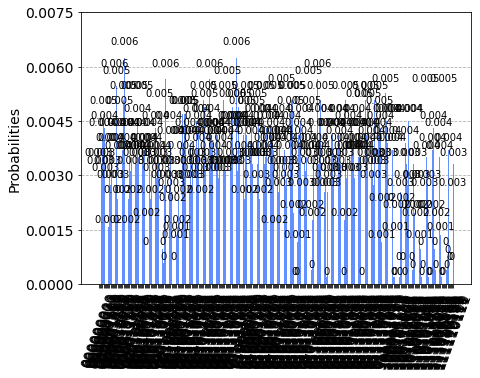

In [10]:
""" run simulator """
shots = 5120
# provider = IBMQ.load_account()
#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')
# job = execute(qc, backend=backend, shots=shots, seed_simulator=12345, backend_options={"fusion_enable":True})
job = execute(qc, backend=backend, shots=shots)
#job = execute(qc, backend=backend, shots=shots)
result = job.result()
count = result.get_counts()
plot_histogram(count)

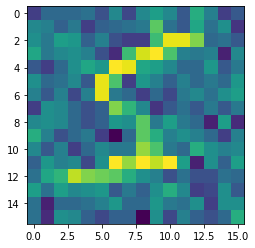

In [11]:
def bitstring_formatting(n_bit, digit):
    binary = bin(digit)[2:]
    for _ in range(n_bit-len(binary)):
        binary = '0' + binary
    return binary

""" decode """
genimg = []
for i in range(2**(2*k-1), 2**(2*k)):
    b = bitstring_formatting(2*k, i)
    b0 = count.get('0'+b)
#     print(i, '0'+b, b0)
    if b0 == None:
        b0 = 0.
    b1 = count.get('1'+b)
#     print(i, '1'+b, b1)
    if b1 == None:
        b1 = 0.
    try:
#         genimg = np.append(genimg, b1*100/(b0+b1))
        genimg = np.append(genimg, shots/len(count)-b0)
    except:
        genimg = np.append(genimg, 0.)
        
for i in range(0, 2**(2*k-1)):
    b = bitstring_formatting(2*k, i)
    b0 = count.get('0'+b)
    if b0 == None:
        b0 = 0.
    try:
        genimg = np.append(genimg, shots/len(count)-b0)
    except:
        genimg = np.append(genimg, 0.)
# print(genimg)
genimg = (genimg - min(genimg)) / (max(genimg)-min(genimg)) *255.
genimg = genimg.astype('int')
genimg = genimg.reshape((2**(k), 2**(k)))
# print(genimg)
plt.imshow(genimg)
plt.show()